# The Annotated GAT (PPI)

This notebook is the 2nd part of the series, please check out **"The Annotated GAT (Cora)"** notebook for a more gentle introduction to GAT. ❤️

The idea of this notebook is to explain how you can use GAT in an **inductive setting**. 

I'll be using the **PPI (protein-protein interaction) dataset** in this notebook.

Here is a representation of the 3D structure of the protein [myoglobin](https://en.wikipedia.org/wiki/Protein) (not like you need to know anything about proteins in order to follow along this notebook it's just that they are beautiful and I love them 🍗❤️)!

<img src="data/readme_pics/protein.png" alt="protein schematic" align="center"/> <br/>

In this notebook you'll get the answers to these questions:

✅ How to load and visualize the PPI dataset? <br/>
✅ How to train/use GAT on PPI (multi-label classification problem)? <br/>
✅ How to visualize different GAT's properties? (mainly attention) <br/>

Awesome, let's start!

In [2]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

import json
import os
import enum

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
import igraph as ig

# Main computation libraries
import numpy as np

# Deep learning related imports
import torch
from torch.utils.data import DataLoader, Dataset

from torch.hub import download_url_to_file
import zipfile

In [3]:
"""
    Contains constants needed for data loading and visualization.

"""


# Supported datasets - only PPI in this notebook
class DatasetType(enum.Enum):
    PPI = 0

    
class GraphVisualizationTool(enum.Enum):
    IGRAPH = 0


# We'll be dumping and reading the data from this directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
PPI_PATH = os.path.join(DATA_DIR_PATH, 'ppi')
PPI_URL = 'https://data.dgl.ai/dataset/ppi.zip'  # preprocessed PPI data from Deep Graph Library

#
# PPI specific constants
#

PPI_NUM_INPUT_FEATURES = 50
PPI_NUM_CLASSES = 121

Note that some parts of this notebook overlap with "The Annotated GAT (Cora)" notebook, so you may see some redundancy. 🙏

With that out of the way we've got the level 1 unlocked (Data 📜). 😍 Let's go!

# Part 1: Understanding your data (become One with the data 📜❤️)

I'll be using the PPI dataset as the running example in this notebook.

Having said that, you may wonder, what's the difference between `transductive` and `inductive` setting? If you're not familiar with GNNs this may appear as a weird concept. But it's quite simple actually.

**Transductive** - you have a single graph (like Cora) you split some **nodes** (and not graphs) into train/val/test training sets. While you're training you'll be using only the labels from your training nodes. BUT. During the forward prop, by the nature of how spatial GNNs work, you'll be aggregating the feature vectors from your neighbors and **some of them may belong to val or even test sets!** The main point is - you **ARE NOT** using their label information but you **ARE** using the structural information and their features.

**Inductive** - you're probably much more familiar with this one if you come from the computer vision or NLP background. You have a set of training graphs, a separate set of val graphs and of course a separate set of test graphs.

Having explained that let's jump into the code and let's load and visualize PPI.

In [4]:
# First let's define this simple function for loading PPI's graph data

def json_read(path):
    with open(path, 'r') as file:
        data = json.load(file)

    return data

Now let's see how we can load PPI!

In [15]:
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.PPI.name.lower():  # Protein-Protein Interaction dataset

        # Instead of checking PPI in, I'd rather download it on-the-fly the first time it's needed (lazy execution ^^)
        if not os.path.exists(PPI_PATH):  # download the first time this is ran
            os.makedirs(PPI_PATH)

            # Step 1: Download the ppi.zip (contains the PPI dataset)
            zip_tmp_path = os.path.join(PPI_PATH, 'ppi.zip')
            download_url_to_file(PPI_URL, zip_tmp_path)

            # Step 2: Unzip it
            with zipfile.ZipFile(zip_tmp_path) as zf:
                zf.extractall(path=PPI_PATH)
            print(f'Unzipping to: {PPI_PATH} finished.')

            # Step3: Remove the temporary resource file
            os.remove(zip_tmp_path)
            print(f'Removing tmp file {zip_tmp_path}.')

        # Collect train/val/test graphs here
        edge_index_list = []
        node_features_list = []
        node_labels_list = []

        # Dynamically determine how many graphs we have per split (avoid using constants when possible)
        num_graphs_per_split_cumulative = [0]

        # Small optimization "trick" since we only need test in the playground.py
        splits = ['test'] if training_config['ppi_load_test_only'] else ['train', 'valid', 'test']

        for split in splits:
            # PPI has 50 features per node, it's a combination of positional gene sets, motif gene sets,
            # and immunological signatures - you can treat it as a black box (I personally have a rough understanding)
            # shape = (NS, 50) - where NS is the number of (N)odes in the training/val/test (S)plit
            # Note: node features are already preprocessed
            node_features = np.load(os.path.join(PPI_PATH, f'{split}_feats.npy'))

            # PPI has 121 labels and each node can have multiple labels associated (gene ontology stuff)
            # SHAPE = (NS, 121)
            node_labels = np.load(os.path.join(PPI_PATH, f'{split}_labels.npy'))

            # Graph topology stored in a special nodes-links NetworkX format
            nodes_links_dict = json_read(os.path.join(PPI_PATH, f'{split}_graph.json'))
            # PPI contains undirected graphs with self edges - 20 train graphs, 2 validation graphs and 2 test graphs
            # The reason I use a NetworkX's directed graph is because we need to explicitly model both directions
            # because of the edge index and the way GAT implementation #3 works
            collection_of_graphs = nx.DiGraph(json_graph.node_link_graph(nodes_links_dict))
            # For each node in the above collection, ids specify to which graph the node belongs to
            graph_ids = np.load(os.path.join(PPI_PATH, F'{split}_graph_id.npy'))
            num_graphs_per_split_cumulative.append(num_graphs_per_split_cumulative[-1] + len(np.unique(graph_ids)))
            # Split the collection of graphs into separate PPI graphs
            for graph_id in range(np.min(graph_ids), np.max(graph_ids) + 1):
                mask = graph_ids == graph_id  # find the nodes which belong to the current graph (identified via id)
                graph_node_ids = np.asarray(mask).nonzero()[0]
                graph = collection_of_graphs.subgraph(graph_node_ids)  # returns the induced subgraph over these nodes
                print(f'Loading {split} graph {graph_id} to CPU. '
                      f'It has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.')

                # shape = (2, E) - where E is the number of edges in the graph
                # Note: leaving the tensors on CPU I'll load them to GPU in the training loop on-the-fly as VRAM
                # is a scarcer resource than CPU's RAM and the whole PPI dataset can't fit during the training.
                edge_index = torch.tensor(list(graph.edges), dtype=torch.long).transpose(0, 1).contiguous()
                edge_index = edge_index - edge_index.min()  # bring the edges to [0, num_of_nodes] range
                edge_index_list.append(edge_index)
                # shape = (N, 50) - where N is the number of nodes in the graph
                node_features_list.append(torch.tensor(node_features[mask], dtype=torch.float))
                # shape = (N, 121), BCEWithLogitsLoss doesn't require long/int64 so saving some memory by using float32
                node_labels_list.append(torch.tensor(node_labels[mask], dtype=torch.float))

                if should_visualize:
                    plot_in_out_degree_distributions(edge_index.numpy(), graph.number_of_nodes(), dataset_name)
                    visualize_graph(edge_index.numpy(), node_labels[mask], dataset_name)

        #
        # Prepare graph data loaders
        #

        # Optimization, do a shortcut in case we only need the test data loader
        if training_config['ppi_load_test_only']:
            data_loader_test = GraphDataLoader(
                node_features_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                node_labels_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                edge_index_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                batch_size=training_config['batch_size'],
                shuffle=False
            )
            return data_loader_test
        else:

            data_loader_train = GraphDataLoader(
                node_features_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                node_labels_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                edge_index_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                batch_size=training_config['batch_size'],
                shuffle=True
            )

            data_loader_val = GraphDataLoader(
                node_features_list[num_graphs_per_split_cumulative[1]:num_graphs_per_split_cumulative[2]],
                node_labels_list[num_graphs_per_split_cumulative[1]:num_graphs_per_split_cumulative[2]],
                edge_index_list[num_graphs_per_split_cumulative[1]:num_graphs_per_split_cumulative[2]],
                batch_size=training_config['batch_size'],
                shuffle=False  # no need to shuffle the validation and test graphs
            )

            data_loader_test = GraphDataLoader(
                node_features_list[num_graphs_per_split_cumulative[2]:num_graphs_per_split_cumulative[3]],
                node_labels_list[num_graphs_per_split_cumulative[2]:num_graphs_per_split_cumulative[3]],
                edge_index_list[num_graphs_per_split_cumulative[2]:num_graphs_per_split_cumulative[3]],
                batch_size=training_config['batch_size'],
                shuffle=False
            )

            return data_loader_train, data_loader_val, data_loader_test
    else:
        raise Exception(f'{dataset_name} not yet supported.')

Nice, there are is this `GraphDataLoader` object that we still haven't defined. We need it in order to load batches of PPI graphs into GAT.

Here we go:

In [16]:
class GraphDataLoader(DataLoader):
    """
    When dealing with batches it's always a good idea to inherit from PyTorch's provided classes (Dataset/DataLoader).

    """
    def __init__(self, node_features_list, node_labels_list, edge_index_list, batch_size=1, shuffle=False):
        graph_dataset = GraphDataset(node_features_list, node_labels_list, edge_index_list)
        # We need to specify a custom collate function, it doesn't work with the default one
        super().__init__(graph_dataset, batch_size, shuffle, collate_fn=graph_collate_fn)


class GraphDataset(Dataset):
    """
    This one just fetches a single graph from the split when GraphDataLoader "asks" it

    """
    def __init__(self, node_features_list, node_labels_list, edge_index_list):
        self.node_features_list = node_features_list
        self.node_labels_list = node_labels_list
        self.edge_index_list = edge_index_list

    # 2 interface functions that need to be defined are len and getitem so that DataLoader can do it's magic
    def __len__(self):
        return len(self.edge_index_list)

    def __getitem__(self, idx):  # we just fetch a single graph
        return self.node_features_list[idx], self.node_labels_list[idx], self.edge_index_list[idx]


def graph_collate_fn(batch):
    """
    The main idea here is to take multiple graphs from PPI as defined by the batch size
    and merge them into a single graph with multiple connected components.

    It's important to adjust the node ids in edge indices such that they form a consecutive range. Otherwise
    the scatter functions in the implementation 3 will fail.

    :param batch: contains a list of edge_index, node_features, node_labels tuples (as provided by the GraphDataset)
    """

    edge_index_list = []
    node_features_list = []
    node_labels_list = []
    num_nodes_seen = 0

    for features_labels_edge_index_tuple in batch:
        # Just collect these into separate lists
        node_features_list.append(features_labels_edge_index_tuple[0])
        node_labels_list.append(features_labels_edge_index_tuple[1])

        edge_index = features_labels_edge_index_tuple[2]  # all of the components are in the [0, N] range
        edge_index_list.append(edge_index + num_nodes_seen)  # very important! translate the range of this component
        num_nodes_seen += len(features_labels_edge_index_tuple[1])  # update the number of nodes we've seen so far

    # Merge the PPI graphs into a single graph with multiple connected components
    node_features = torch.cat(node_features_list, 0)
    node_labels = torch.cat(node_labels_list, 0)
    edge_index = torch.cat(edge_index_list, 1)

    return node_features, node_labels, edge_index

The idea is simple 💡 (as all things should be 😜). In order to pass a batch of graphs into GAT we do the following:

1. During the preprocessing step, we map the edge index from the original range into the [0, N] range, where N is the number of nodes in a given graph. Example: the third graph in the training split may contain nodes [3500, ..., 5000] and thus originally its edge index would be in that very same range, e.g.: [3500, 4232], [3808, 4232], ...]. By subtracting the min element, 3500 in this case, we bring the edge index into [0, 1500] range.

---

2. In the `graph_collate_fn` function, edge indices are in the normalized range i.e. [0, N]. What we do is we shift them such that we end up with a single graph that actually consists out of multiple smaller PPI graphs which are not connected with each other i.e. they represent separate [connected components](https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/). 

---

**Example:** let's say we have 3 graphs in a batch and all 3 edge indices are in the [0, 1000] range. What we'll do is the following: we'll leave the first graph without any modification, we'll shift second graph's range to [1000, 2000], because we had 1000 nodes in the graph that came before, and we'll shift the third graph's range into [2000, 3000], again because we had 2000 nodes that came before this graph. So the final edge index will have nodes in the [0, 3000] range and we treat that as a single graph with multiple connected components. 🤓

Nice, finally let's try and load it. We should also analyze the shapes - that's always a good idea.

In [17]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.PPI.name,
    'should_visualize': False,
    'batch_size': 1,
    'ppi_load_test_only': False  # small optimization for loading test graphs only, we won't use it here
}

data_loader_train, data_loader_val, data_loader_test = load_graph_data(config, device)
# Let's fetch a single batch from the train graph data loader
node_features, node_labels, edge_index = next(iter(data_loader_train))

print('*' * 20)
print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)

Loading train graph 1 to CPU. It has 1767 nodes and 34085 edges.
Loading train graph 2 to CPU. It has 1377 nodes and 31081 edges.
Loading train graph 3 to CPU. It has 2263 nodes and 61907 edges.
Loading train graph 4 to CPU. It has 2339 nodes and 67769 edges.
Loading train graph 5 to CPU. It has 1578 nodes and 37740 edges.
Loading train graph 6 to CPU. It has 1021 nodes and 19237 edges.
Loading train graph 7 to CPU. It has 1823 nodes and 46153 edges.
Loading train graph 8 to CPU. It has 2488 nodes and 72878 edges.
Loading train graph 9 to CPU. It has 591 nodes and 8299 edges.
Loading train graph 10 to CPU. It has 3312 nodes and 109510 edges.
Loading train graph 11 to CPU. It has 2401 nodes and 66619 edges.
Loading train graph 12 to CPU. It has 1878 nodes and 48146 edges.
Loading train graph 13 to CPU. It has 1819 nodes and 47587 edges.
Loading train graph 14 to CPU. It has 3480 nodes and 110234 edges.
Loading train graph 15 to CPU. It has 2794 nodes and 88112 edges.
Loading train graph

Nice! Analyzing the shapes we see the following:
1. This specific PPI train graph (batch size = 1) has 3021 nodes 
2. Each node has **50 features** (check out [data_loading.py](https://github.com/gordicaleksa/pytorch-GAT/blob/main/utils/data_loading.py) for much more detail)
3. PPI has **121 classes** and each node can have multiple classes associated with it (multi-label classification dataset)
4. This graph has 94359 edges (including the self edges)! (Compare this to 13k edges in Cora)
5. PPI has **20 train** graphs, **2 validation** graphs and **2 test** graphs

Additionally the edge index is of `int 64` type. Why? Well it's a constraint that PyTorch is imposing upon us. `index_select` functions require torch.long (i.e. 64 bit integer) and we use those in GAT implementation 3 - that's it.

node_labels can be `float32` because `nn.BCEWithLogitsLoss` doesn't require long/int64 type (compare that to `nn.CrossEntropyLoss`, that we used in the Cora notebook, which does require int64s). So we can save up 2x memory! Not bad.

---

On the "side note", it's always a **good idea to test your code as you're progressing with your project.** 

Data loading is completely orthogonal to the rest of this notebook so we can test it, standalone, and make sure the shapes and datatypes make sense. I use this strategy while developing projects like this one (and in general).

I start with data, I add the loading functionality, I add some visualizations and only then do I usually start developing the deep learning model itself.

Visualizations are a huge bonus, so let's develop them.

# Part 2: Understanding GAT's inner workings 💻🦄

First let's create a high level class where we'll build up `GAT` from `GatLayer` objects. 

It basically just stacks the layers into a nn.Sequential object and additionally since nn.Sequential expects a single input (and it has a single output) I just pack the data (features, edge index) into a tuple - *pure syntactic sugar*. 

In [22]:
import torch.nn as nn
from torch.optim import Adam


class GAT(torch.nn.Module):
    """
    The most interesting and hardest implementation is implementation #3.
    Imp1 and imp2 differ in subtle details but are basically the same thing.

    So I'll focus on imp #3 in this notebook.

    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    # data is just a (in_nodes_features, edge_index) tuple, I had to do it like this because of the nn.Sequential:
    # https://discuss.pytorch.org/t/forward-takes-2-positional-arguments-but-3-were-given-for-nn-sqeuential-with-linear-layers/65698
    def forward(self, data):
        return self.gat_net(data)

Now for the fun part let's define the layer. 

I really don't think that I can explain it any better, using words, than you taking your time to digest the code and the comments.

Also make sure to check out [my video on GAT](https://www.youtube.com/watch?v=uFLeKkXWq2c) before you start losing time trying to figure it out "from scratch". It's always good to have some theoretical background at your hand.

In [38]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """
    
    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)
        print("features_proj (node 1, head 1) = ", nodes_features_proj[1][1])

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

The main idea that leads to huge savings is that we calculate the scores only for the nodes that will actually be used and not for every imaginable combination (that would be valid only in a fully-connected graph).

Once we compute the `"left"` scores and the `"right"` scores, we "lift" them up using the edge index. That way
if the edge `1->2` is not present in the graph we won't have those score pairs in our data structure.

After adding lifted "left" and "right" (or maybe a better naming would be source and target) scores we do smart `neighborhood-aware softmax` - so that the semantics of GAT is respected. After doing the `scatter add` (which you should take your time to understand and go through the docs) we can combine the projected feature vectors, and voilà, we got ourselves a fully-blown GAT layer.

---

Take your time and **be patient**! Especially if you're new to GNNs. 

I didn't learn all of this in 1 day, it takes time for the knowledge to sink in. You'll get there as well! ❤️ (if you're not already there 😜)

Having said that, we've got the level 3 unlocked (model training 💪). 😍

We have the data 📜 ready, we have the GAT model 🦄 ready, let's start training this beast! 💪

# Part 3: Training GAT 💪 (Multi-label classification on PPI!)

Phew, well the hardest part is behind us. Let's know create a simple training loop where the goal is to learn to assign multiple labels to PPI nodes.

But first let's define some relevant constants. 

In [20]:
from torch.utils.tensorboard import SummaryWriter


# 3 different model training/eval phases used in train.py
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

    
writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default


# Global vars used for early stopping. After some number of epochs (as defined by the patience_period var) without any
# improvement on the validation dataset (measured via micro-F1 metric), we'll break out from the training loop.
BEST_VAL_MICRO_F1 = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

Also, let's define a couple of functions that will be useful while training the model.

The training state contains a lot of useful `metadata` which we can later use. You can imagine that saving the test accuracy of your model is important, especially when you're training your models on a cloud - it makes the organization so much better.

In [25]:
import git
import re  # regex


def get_training_state(training_config, model):
    training_state = {
        "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha,

        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_perf": training_config['test_perf'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # don't print state_dict it's a bunch of numbers...
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')
    

# This one makes sure we don't overwrite the valuable model binaries (feel free to ignore - not crucial to GAT method)
def get_available_binary_name(dataset_name='unknown'):
    prefix = f'gat_{dataset_name}'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

Nice, now `argparse` is just a nice way to **organize** your program settings:

In [ ]:
import argparse


def get_training_args():
    parser = argparse.ArgumentParser()

    # Training related
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=60)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=100)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=0)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)
    parser.add_argument("--force_cpu", type=bool, help='use CPU if your GPU is too small', default=False)

    # Dataset related (note: we need the dataset name for metadata and related stuff, and not for picking the dataset)
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.PPI.name)
    parser.add_argument("--batch_size", type=int, help='number of graphs in a batch', default=2)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=10)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=5)
    args = parser.parse_args('')

    # I'm leaving the hyperparam values as reported in the paper, but I experimented a bit and the comments suggest
    # how you can make GAT achieve an even higher micro-F1 or make it smaller
    gat_config = {
        # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
        #"num_of_layers": 3,  # PPI has got 42% of nodes with all 0 features - that's why 3 layers are useful
        "num_of_layers": 1,
        #"num_heads_per_layer": [4, 4, 6],  # other values may give even better results from the reported ones
        "num_heads_per_layer": [8],
        #"num_features_per_layer": [PPI_NUM_INPUT_FEATURES, 64, 64, PPI_NUM_CLASSES],  # 64 would also give ~0.975 uF1!
        "num_features_per_layer": [PPI_NUM_INPUT_FEATURES, PPI_NUM_CLASSES],
        #"add_skip_connection": True,  # skip connection is very important! (keep it otherwise micro-F1 is almost 0)
        "add_skip_connection": False,
        "bias": False,  # bias doesn't matter that much
        "dropout": 0.0,  # dropout hurts the performance (best to keep it at 0)
    }

    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)
    training_config['ppi_load_test_only'] = False  # load both train/val/test data loaders (don't change it)

    # Add additional config information
    training_config.update(gat_config)

    return training_config

Now for the juicy part. 🍪🎅

Here, we organize, high-level, everything we need for training GAT. Just combining the components we already learned.

In [ ]:
import time


def train_gat_ppi(config):
    """
    Very similar to Cora's training script. The main differences are:
    1. Using dataloaders since we're dealing with an inductive setting - multiple graphs per batch
    2. Doing multi-class classification (BCEWithLogitsLoss) and reporting micro-F1 instead of accuracy
    3. Model architecture and hyperparams are a bit different (as reported in the GAT paper)

    """
    global BEST_VAL_MICRO_F1, BEST_VAL_LOSS

    # Checking whether you have a strong GPU. Since PPI training requires almost 8 GBs of VRAM
    # I've added the option to force the use of CPU even though you have a GPU on your system (but it's too weak).
    device = torch.device("cuda" if torch.cuda.is_available() and not config['force_cpu'] else "cpu")

    # Step 1: prepare the data loaders
    data_loader_train, data_loader_val, data_loader_test = load_graph_data(config, device)

    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False  # no need to store attentions, used only in playground.py for visualizations
    ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    # The decorator function makes things cleaner since there is a lot of redundancy between the train and val loops
    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        config['patience_period'],
        time.time())

    BEST_VAL_MICRO_F1, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]  # reset vars used for early stopping

    # Step 4: Start the training procedure
    for epoch in range(config['num_of_epochs']):
        # Training loop
        main_loop(phase=LoopPhase.TRAIN, data_loader=data_loader_train, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, data_loader=data_loader_val, epoch=epoch)
            except Exception as e:  # "patience has run out" exception :O
                print(str(e))
                break  # break out from the training loop

    # Step 5: Potentially test your model
    # Don't overfit to the test dataset - only when you've fine-tuned your model on the validation dataset should you
    # report your final loss and micro-F1 on the test dataset. Friends don't let friends overfit to the test data. <3
    if config['should_test']:
        micro_f1 = main_loop(phase=LoopPhase.TEST, data_loader=data_loader_test)
        config['test_perf'] = micro_f1

        print('*' * 50)
        print(f'Test micro-F1 = {micro_f1}')
    else:
        config['test_perf'] = -1

    # Save the latest GAT in the binaries directory
    torch.save(
        get_training_state(config, gat),
        os.path.join(BINARIES_PATH, get_available_binary_name(config['dataset_name']))
    )

🎉🎉🎉 

Now for the core part of the training - the main loop, as I've dubbed it. 

I've organized it like this so that I don't have to copy/paste bunch of the same code for train/val/test loops.

**Friends don't let friends copy/paste (unless it's from the Stack Overflow)**

In [ ]:
from sklearn.metrics import f1_score


# Simple decorator function so that I don't have to pass arguments that don't change from epoch to epoch
def get_main_loop(config, gat, sigmoid_cross_entropy_loss, optimizer, patience_period, time_start):

    device = next(gat.parameters()).device  # fetch the device info from the model instead of passing it as a param

    def main_loop(phase, data_loader, epoch=0):
        global BEST_VAL_MICRO_F1, BEST_VAL_LOSS, PATIENCE_CNT, writer

        # Certain modules behave differently depending on whether we're training the model or not.
        # e.g. nn.Dropout - we only want to drop model weights during the training.
        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        # Iterate over batches of graph data (2 graphs per batch was used in the original paper for the PPI dataset)
        # We merge them into a single graph with 2 connected components, that's the main idea. After that
        # the implementation #3 is agnostic to the fact that those are multiple and not a single graph!
        for batch_idx, (node_features, gt_node_labels, edge_index) in enumerate(data_loader):
            # Push the batch onto GPU - note PPI is to big to load the whole dataset into a normal GPU
            # it takes almost 8 GBs of VRAM to train it on a GPU
            edge_index = edge_index.to(device)
            node_features = node_features.to(device)
            gt_node_labels = gt_node_labels.to(device)

            # I pack data into tuples because GAT uses nn.Sequential which expects this format
            graph_data = (node_features, edge_index)

            # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index)
            # shape = (N, C) where N is the number of nodes in the batch and C is the number of classes (121 for PPI)
            # GAT imp #3 is agnostic to the fact that we actually have multiple graphs
            # (it sees a single graph with multiple connected components)
            nodes_unnormalized_scores = gat(graph_data)[0]

            # Example: because PPI has 121 labels let's make a simple toy example that will show how the loss works.
            # Let's say we have 3 labels instead and a single node's unnormalized (raw GAT output) scores are [-3, 0, 3]
            # What this loss will do is first it will apply a sigmoid and so we'll end up with: [0.048, 0.5, 0.95]
            # next it will apply a binary cross entropy across all of these and find the average, and that's it!
            # So if the true classes were [0, 0, 1] the loss would be (-log(1-0.048) + -log(1-0.5) + -log(0.95))/3.
            # You can see that the logarithm takes 2 forms depending on whether the true label is 0 or 1,
            # either -log(1-x) or -log(x) respectively. Easy-peasy. <3
            loss = sigmoid_cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

            if phase == LoopPhase.TRAIN:
                optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
                loss.backward()  # compute the gradients for every trainable weight in the computational graph
                optimizer.step()  # apply the gradients to weights

            # Calculate the main metric - micro F1, check out this link for what micro-F1 exactly is:
            # https://www.kaggle.com/enforcer007/what-is-micro-averaged-f1-score

            # Convert unnormalized scores into predictions. Explanation:
            # If the unnormalized score is bigger than 0 that means that sigmoid would have a value higher than 0.5
            # (by sigmoid's definition) and thus we have predicted 1 for that label otherwise we have predicted 0.
            pred = (nodes_unnormalized_scores > 0).float().cpu().numpy()
            gt = gt_node_labels.cpu().numpy()
            micro_f1 = f1_score(gt, pred, average='micro')

            #
            # Logging
            #

            global_step = len(data_loader) * epoch + batch_idx
            if phase == LoopPhase.TRAIN:
                # Log metrics
                if config['enable_tensorboard']:
                    writer.add_scalar('training_loss', loss.item(), global_step)
                    writer.add_scalar('training_micro_f1', micro_f1, global_step)

                # Log to console
                if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0 and batch_idx == 0:
                    print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] |'
                          f' epoch={epoch + 1} | batch={batch_idx + 1} | train micro-F1={micro_f1}.')

                # Save model checkpoint
                if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0 and batch_idx == 0:
                    ckpt_model_name = f'gat_{config["dataset_name"]}_ckpt_epoch_{epoch + 1}.pth'
                    config['test_perf'] = -1  # test perf not calculated yet, note: perf means main metric micro-F1 here
                    torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

            elif phase == LoopPhase.VAL:
                # Log metrics
                if config['enable_tensorboard']:
                    writer.add_scalar('val_loss', loss.item(), global_step)
                    writer.add_scalar('val_micro_f1', micro_f1, global_step)

                # Log to console
                if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0 and batch_idx == 0:
                    print(f'GAT validation: time elapsed= {(time.time() - time_start):.2f} [s] |'
                          f' epoch={epoch + 1} | batch={batch_idx + 1} | val micro-F1={micro_f1}')

                # The "patience" logic - should we break out from the training loop? If either validation micro-F1
                # keeps going up or the val loss keeps going down we won't stop
                if micro_f1 > BEST_VAL_MICRO_F1 or loss.item() < BEST_VAL_LOSS:
                    BEST_VAL_MICRO_F1 = max(micro_f1, BEST_VAL_MICRO_F1)  # keep track of the best validation micro_f1 so far
                    BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)  # and the minimal loss
                    PATIENCE_CNT = 0  # reset the counter every time we encounter new best micro_f1
                else:
                    PATIENCE_CNT += 1  # otherwise keep counting

                if PATIENCE_CNT >= patience_period:
                    raise Exception('Stopping the training, the universe has no more patience for this training.')

            else:
                return micro_f1  # in the case of test phase we just report back the test micro_f1

    return main_loop  # return the decorated function

That was all we needed! Let's train it! 💪💪💪

Keep in mind that PPI training takes much more time than training on Cora.

Additionally you'll need 8+ GBs GPU if you want to train it on your GPU. Alternatively you can set the `--force_cpu` flag in the `get_training_args` function to train it on your CPU or simply use the pre-checked-in model I provided. The following section, part 4, doesn't depend on this so you can skip it if you want.

In [ ]:
# Train the graph attention network (GAT)
train_gat_ppi(get_training_args())

Nice!!! 🎉🎉🎉 Level 4 unlocked (GAT visualizations 🔮). 😍

We just achieved `0.978` micro-F1 on PPI's test graphs! The same numbers as reported in the original GAT paper!

So we now have everything in place:
1. PPI data loading and visualizations 📜 -> checked
2. GAT model defined 🦄 -> checked
3. Training loop setup and the trained model binaries 💪 -> checked

Now let's play the GAT model under a microscope 🔬🔬🔬 and understand the weights we got - we can do that in many ways.

# Part 4: Visualizing GAT on PPI 🔮

I tried visualizing PPI's 2D embeddings using t-SNE without any label/color information but it's not that informative, so we'll only do **attention** and **entropy visualizations** in this notebook.

Let's start by defining some functions we'll need. 

The following cell's code snippet will get called multiple times so let's just extract it inside a function - a nice modular design.

*Note: the main reason is actually that igraph is having problems with Jupyter so I'm working around it, check out the [original code](https://github.com/gordicaleksa/pytorch-GAT/blob/main/playground.py#L147) if you're curious* 😂

In [18]:
def gat_forward_pass(model_name, dataset_name):
    device = torch.device("cpu")  # checking whether you have a GPU, I hope so!

    config = {
        'dataset_name': dataset_name,
        'should_visualize': False,  # don't visualize the dataset
        'batch_size': 2,  # we're using 2 graphs per batch as reported in the paper
        'ppi_load_test_only': True  # optimization, we're loading only test graphs
    }

    # Step 1: Prepare the data
    data_loader_test = load_graph_data(config, device)
    node_features, node_labels, topology = next(iter(data_loader_test))
    node_features = node_features.to(device)  # need to explicitly push them to GPU since PPI eats up a lot of VRAM
    node_labels = node_labels.to(device)
    topology = topology.to(device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    model_state = torch.load(model_path, map_location=torch.device('cpu'))

    gat = GAT(
        num_of_layers=model_state['num_of_layers'],
        num_heads_per_layer=model_state['num_heads_per_layer'],
        num_features_per_layer=model_state['num_features_per_layer'],
        add_skip_connection=model_state['add_skip_connection'],
        bias=model_state['bias'],
        dropout=model_state['dropout'],
        log_attention_weights=True
    ).to(device)

    print_model_metadata(model_state)
    assert model_state['dataset_name'].lower() == dataset_name.lower(), \
        f"The model was trained on {model_state['dataset_name']} but you're calling it on {dataset_name}."
    gat.load_state_dict(model_state["state_dict"], strict=True)
    gat.eval()  # some layers like nn.Dropout behave differently in train vs eval mode so this part is important

    # Step 3: Calculate the things we'll need for different visualization types (attention, scores, edge_index)

    # This context manager is important (and you'll often see it), otherwise PyTorch will eat much more memory.
    # It would be saving activations for backprop but we are not going to do any model training just the prediction.
    with torch.no_grad():
        # Step 3: Run predictions and collect the high dimensional data
        all_nodes_unnormalized_scores, _ = gat((node_features, topology))  # shape = (N, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()

    return all_nodes_unnormalized_scores, topology, node_labels, gat

Nice that one just produces the data that'll get consumed in the downstream visualizations that you'll see defined in the following cells.

# Visualizing neighborhood attention 📣

So, you now hopefully understand how GAT roughly works, and so you know that during the aggregation stage every single node assigns an **attention coefficient** to every single one of its neighbors (including itself since we added self edges).

Any ideas on what we could visualize? Well let's pick some nodes and see which attention patterns they've learned!

The first idea that may pop to your mind is to draw edges **thicker** if the **attention is larger** and vice versa (*well that's also the last idea that pops to my mind*).

Let's do it!

Loading test graph 23 to CPU. It has 3224 nodes and 103872 edges.
Loading test graph 24 to CPU. It has 2300 nodes and 63628 edges.

***** Model training metadata: *****
commit_hash: fc0d286f4566a311134869470d0ee9c88b7f1bce
dataset_name: PPI
num_of_epochs: 200
test_perf: 0.6010310668414757
num_of_layers: 1
num_heads_per_layer: [8]
num_features_per_layer: [50, 121]
add_skip_connection: False
bias: False
dropout: 0.0
*************************************

features_proj (node 0, head 1) =  tensor([-1.0884,  0.1125, -4.2577,  0.6560, -4.1832, -1.0960,  0.1966, -0.8447,
        -6.6560, -2.8093, -5.4067,  2.9334,  2.3171, -1.2962, -3.7417, -2.5590,
        -6.1468, -3.4637, -2.8742, -3.1723, -0.2643, -0.4037, -3.0179, -7.3067,
        -2.5935, -2.7346, -4.5094, -0.4673, -5.5418, -2.6939, -0.9223,  0.0310,
        -0.7240, -1.7213, -2.9464, -2.8111,  1.8250, -7.3265, -4.3719, -5.0126,
        -1.5536,  1.6187, -2.4586, -1.6744,  4.3152, -2.6729, -2.2695, -3.0516,
        -1.8156, -2.2391, -3.

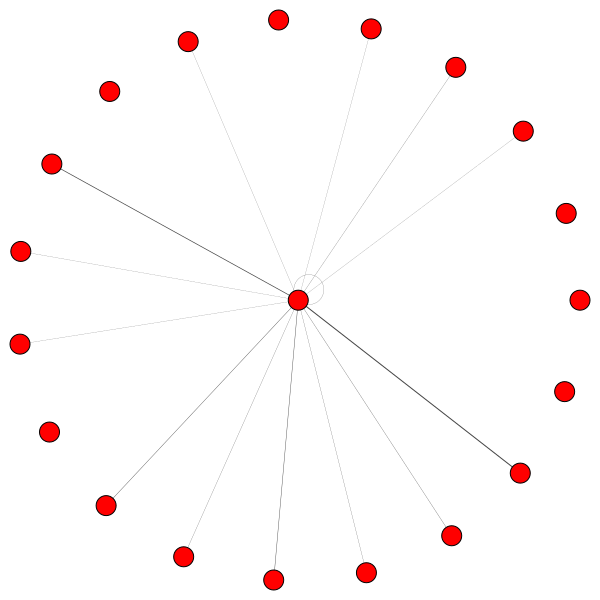

In [39]:
# Again, unfortunately, igraph is having some problems running in Jupyter so I have to flatten out the content here
# including the for loops - no for loops with igraph in Jupyter folks.

model_name=r'gat_PPI_000001.pth'  # This model is checked-in, feel free to use the one you trained
dataset_name=DatasetType.PPI.name

# Fetch the data we'll need to create visualizations
all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)

head_to_visualize = 0  # plot attention from this multi-head attention's head
gat_layer_id = 0  # plot attention from this GAT layer

assert gat_layer_id == 0, f'Attention visualization for {dataset_name} is only available for the first layer.'

# Build up the complete graph
# node_features shape = (N, FIN), where N is the number of nodes and FIN number of input features
total_num_of_nodes = len(all_nodes_unnormalized_scores)
complete_graph = ig.Graph()
complete_graph.add_vertices(total_num_of_nodes)  # igraph creates nodes with ids [0, total_num_of_nodes - 1]
edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :]))  # igraph requires this format
complete_graph.add_edges(edge_index_tuples)

target_node_ids = edge_index[1]
source_nodes = edge_index[0]

#
# Pick the node id you want to visualize the attention for!
#

# since for loops won't work with igraph just set some number here
target_node_id = 0  # random node

# Step 1: Find the neighboring nodes to the target node
# Note: self edges are included so the target node is it's own neighbor (Alexandro yo soy tu madre)
src_nodes_indices = torch.eq(target_node_ids, target_node_id)
source_node_ids = source_nodes[src_nodes_indices].cpu().numpy()
print("source node ids =", source_node_ids)
size_of_neighborhood = len(source_node_ids)

# Step 2: Fetch their labels
labels = node_labels[source_node_ids].cpu().numpy()

# Step 3: Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
# attention shape = (N, NH, 1) -> (N, NH) - we just squeeze the last dim it's superfluous
all_attention_weights = gat.gat_net[gat_layer_id].attention_weights.squeeze(dim=-1)
attention_weights = all_attention_weights[src_nodes_indices, head_to_visualize].cpu().numpy()
print("attention weights =", attention_weights)
# PPI's attention pattern is much less uniform than Cora's
print(f'Max attention weight = {np.max(attention_weights)} and min = {np.min(attention_weights)}')
attention_weights /= np.max(attention_weights)  # rescale the biggest weight to 1 for nicer plotting

# Build up the neighborhood graph whose attention we want to visualize
# igraph constraint - it works with contiguous range of ids so we map e.g. node 497 to 0, 12 to 1, etc.
id_to_igraph_id = dict(zip(source_node_ids, range(len(source_node_ids))))
ig_graph = ig.Graph()
ig_graph.add_vertices(size_of_neighborhood)
ig_graph.add_edges([(id_to_igraph_id[neighbor], id_to_igraph_id[target_node_id]) for neighbor in source_node_ids])

# Prepare the visualization settings dictionary and plot
visual_style = {
    "edge_width": attention_weights,  # make edges as thick as the corresponding attention weight
    "layout": ig_graph.layout_reingold_tilford_circular()  # layout for tree-like graphs
}

ig.plot(ig_graph, **visual_style)

# Post-processing for Parallel-GAT project

## Export Trained Model

In [6]:
model_name=r'models/binaries/gat_PPI_000001.pth'
model_state = torch.load(model_name, map_location=torch.device("cpu"))


In [7]:
print(model_state)

{'commit_hash': 'fc0d286f4566a311134869470d0ee9c88b7f1bce', 'dataset_name': 'PPI', 'num_of_epochs': 200, 'test_perf': 0.6010310668414757, 'num_of_layers': 1, 'num_heads_per_layer': [8], 'num_features_per_layer': [50, 121], 'add_skip_connection': False, 'bias': False, 'dropout': 0.0, 'state_dict': OrderedDict([('gat_net.0.scoring_fn_target', tensor([[[ 4.2526e-02, -2.2061e-02,  1.7813e-01,  9.5327e-02,  1.9419e-02,
          -1.3862e-02,  9.5293e-02, -7.1660e-02,  9.5219e-02,  2.0901e-03,
           5.1543e-02,  1.7303e-02,  2.4387e-01,  3.5561e-02, -3.2772e-02,
           5.8154e-02, -7.1884e-02, -2.8155e-02,  2.3671e-02, -2.3235e-02,
          -4.7205e-02,  1.7999e-02,  1.1128e-02,  6.4638e-02, -4.2352e-02,
           1.5734e-01,  2.4488e-01,  5.5371e-02,  3.1932e-02,  1.1434e-02,
           2.4638e-02, -1.9278e-02,  3.3447e-01,  1.1334e-01,  1.9546e-02,
          -2.7575e-01,  5.0496e-03, -2.7683e-03,  5.1481e-03, -1.1883e-02,
          -3.6398e-02, -7.5255e-02, -1.9376e-02,  1.1031e

In [8]:
param_dict = dict()
for key, value in model_state["state_dict"].items():
    param_dict[key] = value.cpu().detach().numpy().tolist()
text_file = open("./gat_ppi_model.json", "w")
text_file.write(json.dumps(param_dict, indent=4))
text_file.close()

In [9]:
len(param_dict["gat_net.0.linear_proj.weight"])

968

In [ ]:
# source: 8 (num_heads) x out_dim (121)
model_file = open("./gat_ppi_model.txt", "w")
source_params = param_dict["gat_net.0.scoring_fn_source"][0]
for row in source_params:
    line = ""
    for elem in row:
        if line == "":
            line = str(elem)
        else:
            line += " " + str(elem)
    line += "\n"
    model_file.write(line)
# target: 8 (num_heads) x out_dim (121)
target_params = param_dict["gat_net.0.scoring_fn_target"][0]
for row in target_params:
    line = ""
    for elem in row:
        if line == "":
            line = str(elem)
        else:
            line += " " + str(elem)
    line += "\n"
    model_file.write(line)
    
# linear_proj: 968 (121 output_dim * 8 num_heads) x 50 (input_dim)
linear_proj = param_dict["gat_net.0.linear_proj.weight"]
for row in linear_proj:
    line = ""
    for elem in row:
        if line == "":
            line = str(elem)
        else:
            line += " " + str(elem)
    line += "\n"
    model_file.write(line)
model_file.close()

## Export One Test Graph

In [10]:
def load_one_test_graph():
    PPI_PATH = "./data/ppi/"
    node_features = np.load(os.path.join(PPI_PATH, 'test_feats.npy'))
    node_labels = np.load(os.path.join(PPI_PATH, 'test_labels.npy'))
    # Graph topology stored in a special nodes-links NetworkX format
    nodes_links_dict = json_read(os.path.join(PPI_PATH, 'test_graph.json'))
    # PPI contains undirected graphs with self edges - 20 train graphs, 2 validation graphs and 2 test graphs
    # The reason I use a NetworkX's directed graph is because we need to explicitly model both directions
    # because of the edge index and the way GAT implementation #3 works
    collection_of_graphs = nx.DiGraph(json_graph.node_link_graph(nodes_links_dict))
    # For each node in the above collection, ids specify to which graph the node belongs to
    graph_ids = np.load(os.path.join(PPI_PATH, 'test_graph_id.npy'))
    # Only load test graph 23
    mask = graph_ids == 23  # find the nodes which belong to the current graph (identified via id)
    graph_node_ids = np.asarray(mask).nonzero()[0]
    graph = collection_of_graphs.subgraph(graph_node_ids)
    return graph, node_features[mask], node_labels[mask]

In [11]:
test_graph, features, labels = load_one_test_graph()

In [12]:
print("number of nodes = ", len(test_graph.nodes), " edges =", len(test_graph.edges))

number of nodes =  3224  edges = 103872


In [13]:
sorted(test_graph.edges)

[(0, 0),
 (0, 163),
 (0, 165),
 (0, 569),
 (0, 633),
 (0, 634),
 (0, 685),
 (0, 702),
 (0, 793),
 (0, 796),
 (0, 1230),
 (0, 1804),
 (0, 1864),
 (0, 2350),
 (0, 2593),
 (0, 2746),
 (0, 2771),
 (0, 3000),
 (0, 3108),
 (0, 3149),
 (1, 1),
 (1, 16),
 (1, 67),
 (2, 2),
 (2, 8),
 (2, 48),
 (2, 201),
 (2, 442),
 (2, 489),
 (2, 547),
 (2, 672),
 (2, 684),
 (2, 685),
 (2, 808),
 (2, 826),
 (2, 1073),
 (2, 1561),
 (2, 1707),
 (2, 1883),
 (2, 2061),
 (2, 2218),
 (2, 2305),
 (2, 2308),
 (2, 2478),
 (2, 2714),
 (2, 2724),
 (2, 3134),
 (2, 3151),
 (3, 3),
 (3, 90),
 (3, 125),
 (3, 126),
 (3, 186),
 (3, 261),
 (3, 265),
 (3, 332),
 (3, 360),
 (3, 361),
 (3, 363),
 (3, 366),
 (3, 367),
 (3, 482),
 (3, 590),
 (3, 591),
 (3, 592),
 (3, 668),
 (3, 732),
 (3, 796),
 (3, 815),
 (3, 892),
 (3, 965),
 (3, 1064),
 (3, 1127),
 (3, 1130),
 (3, 1134),
 (3, 1267),
 (3, 1306),
 (3, 1311),
 (3, 1312),
 (3, 1313),
 (3, 1351),
 (3, 1441),
 (3, 1492),
 (3, 1529),
 (3, 1746),
 (3, 1788),
 (3, 1864),
 (3, 1883),
 (3, 1

### Export Graph Topology (Sparse Matrix Format)

In [ ]:
from collections import defaultdict
adj_file = open("./ppi_adj.txt", "w")
# first line: number of nodes, number of edges
adj_file.write(str(test_graph.number_of_nodes()) + " " + str(test_graph.number_of_edges()) + "\n")
# second line: column indices of each non-zero element
sorted_edges = sorted(test_graph.edges)
for edge in sorted_edges:
    adj_file.write(str(edge[1]) + " ")
adj_file.write("\n")
# third line: number of non-zero elements in last row
adj_file.write("0")
edge_counter = defaultdict(lambda: 0)
for edge in sorted_edges:
    edge_counter[edge[0]] += 1
counter = 0
for i in range(test_graph.number_of_nodes()):
    counter += edge_counter[i]
    adj_file.write(" " + str(counter))
adj_file.write("\n")
adj_file.close()

### Export Feature

In [ ]:
feature_file = open("./ppi_features.txt", "w")
for feature in features:
    for feat in feature:
        feature_file.write(str(feat) + " ")
    feature_file.write("\n")
feature_file.close()

### Export Labels

In [ ]:
label_file = open("./ppi_labels.txt", "w")
# 3224 lines, each line is a 121 dimension vector
for label in labels:
    for elem in label:
        label_file.write(str(elem) + " ")
    label_file.write("\n")
label_file.close()